In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import adjusted_rand_score
from statsmodels.formula.api import ols

In [9]:
mcdonalds = pd.read_csv("/content/mcdonalds.csv")

In [10]:
MD_x = (mcdonalds.iloc[:, :11] == "Yes").astype(int)

In [11]:

pca = PCA()
MD_pca = pca.fit_transform(MD_x)

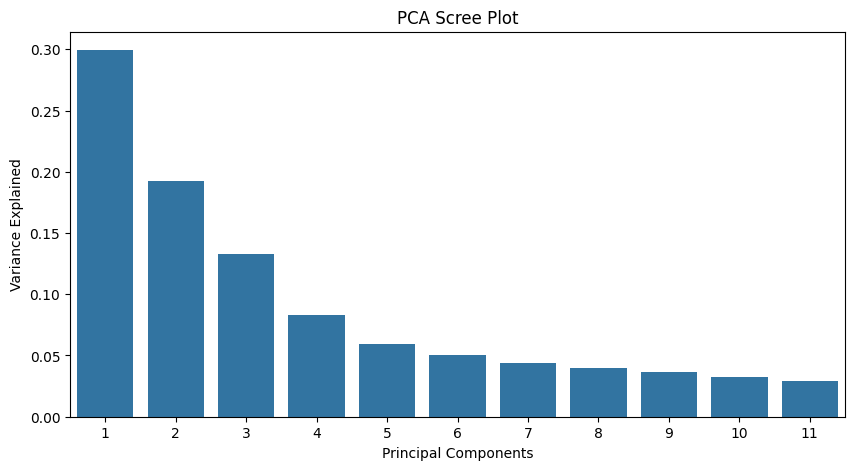

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(1, len(pca.explained_variance_ratio_) + 1), y=pca.explained_variance_ratio_)
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.title("PCA Scree Plot")
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, random_state=1234, n_init=10)
clusters = kmeans.fit_predict(MD_x)

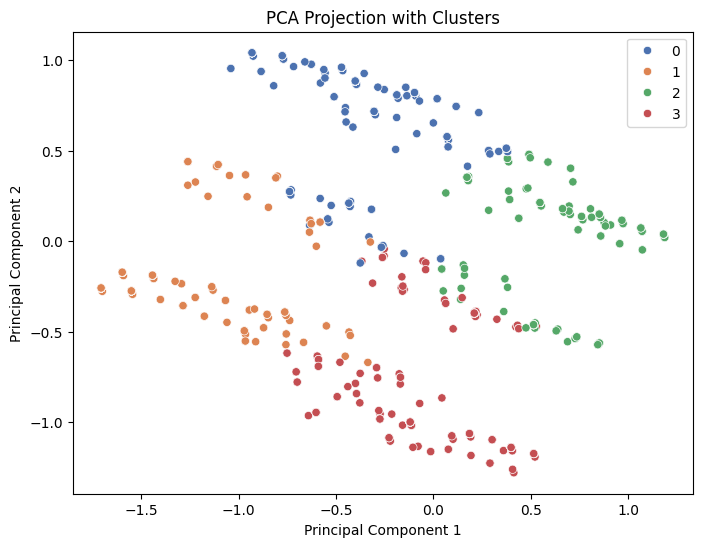

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=MD_pca[:, 0], y=MD_pca[:, 1], hue=clusters, palette="deep")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection with Clusters")
plt.show()

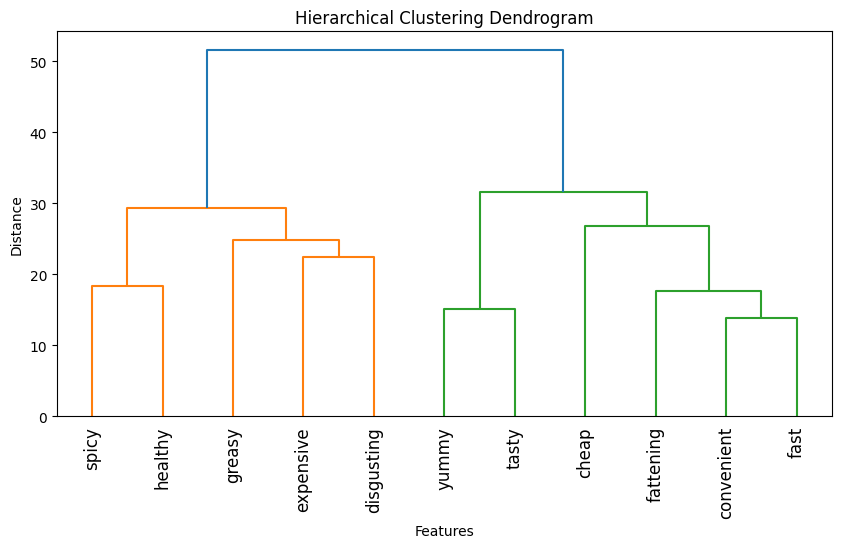

In [15]:
dist_matrix = linkage(MD_x.T, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(dist_matrix, labels=MD_x.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

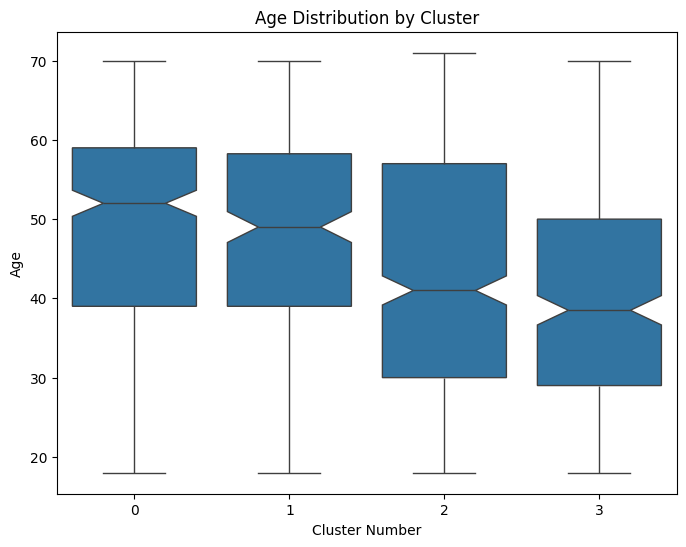

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=clusters, y=mcdonalds["Age"], notch=True)
plt.xlabel("Cluster Number")
plt.ylabel("Age")
plt.title("Age Distribution by Cluster")
plt.show()

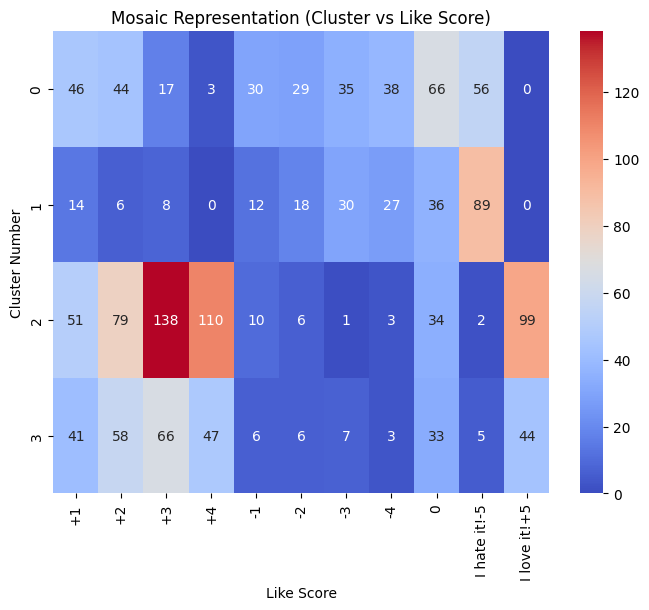

In [17]:
like_table = pd.crosstab(clusters, mcdonalds["Like"])
plt.figure(figsize=(8, 6))
sns.heatmap(like_table, annot=True, fmt="d", cmap="coolwarm")
plt.xlabel("Like Score")
plt.ylabel("Cluster Number")
plt.title("Mosaic Representation (Cluster vs Like Score)")
plt.show()

In [33]:
from statsmodels.formula.api import ols
import patsy


mcdonalds["Like"] = pd.Categorical(mcdonalds["Like"])
mcdonalds["Like.n"] = 6 - mcdonalds["Like"].cat.codes


MD_x = (mcdonalds.iloc[:, :11] == "Yes").astype(int)


formula = "Like.n ~ " + " + ".join([f"Q('{col}')" for col in MD_x.columns])


try:
    model = ols(formula, data=mcdonalds).fit()
    print(model.summary())
except patsy.PatsyError as e:
    print("Patsy Error:", e)
except Exception as e:
    print("Other Error:", e)


Patsy Error: Error evaluating factor: AttributeError: 'Series' object has no attribute 'n'
    Like.n ~ Q('yummy') + Q('convenient') + Q('spicy') + Q('fattening') + Q('greasy') + Q('fast') + Q('cheap') + Q('tasty') + Q('expensive') + Q('healthy') + Q('disgusting')
    ^^^^^^


In [34]:
visit_mean = mcdonalds.groupby(clusters)["VisitFrequency"].apply(lambda x: x.mode()[0]) # Calculate the mode (most frequent value) for 'VisitFrequency' within each cluster
like_mean = mcdonalds.groupby(clusters)["Like.n"].mean()
female_ratio = mcdonalds.groupby(clusters)["Gender"].apply(lambda x: (x == "Female").mean())

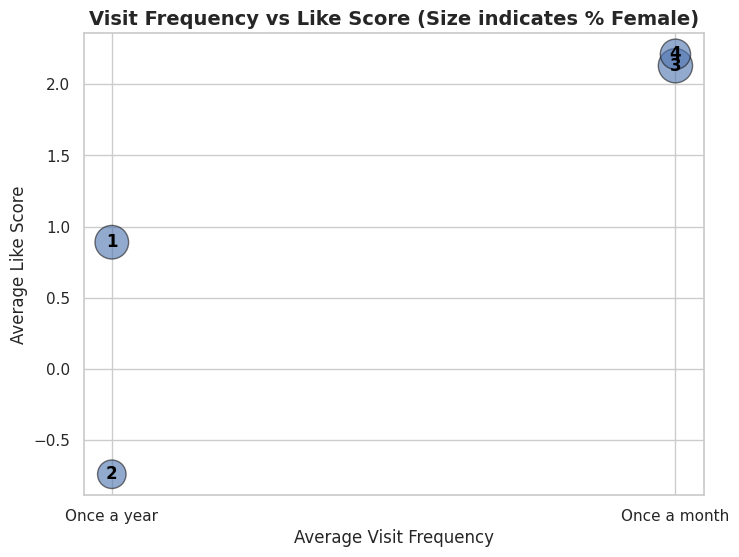

In [36]:
import seaborn as sns


sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
plt.scatter(visit_mean, like_mean, s=1000 * female_ratio, alpha=0.6, edgecolors="k")

for i, txt in enumerate(range(len(visit_mean))):
    plt.annotate(str(txt + 1), (visit_mean.iloc[i], like_mean.iloc[i]), fontsize=12,
                 ha="center", va="center", fontweight="bold", color="black")

plt.xlabel("Average Visit Frequency", fontsize=12)
plt.ylabel("Average Like Score", fontsize=12)
plt.title("Visit Frequency vs Like Score (Size indicates % Female)", fontsize=14, fontweight="bold")
plt.show()
